## Importing libraries

In [1]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline


## Importing data and concating on mcn json files

In [41]:
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup_with_category_3more_name.json') as f:
    data = json.load(f)

train_3more_name_df = pd.DataFrame(data)
train_3more_name_df = train_3more_name_df.T

In [42]:
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup_with_category_3more_name.json') as f:
    data = json.load(f)

test_3more_name_df = pd.DataFrame(data)
test_3more_name_df = test_3more_name_df.T

In [43]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/fashion_compatibility_mcn/data/valid_no_dup_with_category_3more_name.json') as f:
    data = json.load(f)
valid_3more_name_df = pd.DataFrame(data)
valid_3more_name_df = valid_3more_name_df.T


In [9]:
train_3more_name_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2463 entries, 119704139 to 148787971
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   upper      2000 non-null   object
 1   bottom     2153 non-null   object
 2   shoe       2314 non-null   object
 3   bag        1994 non-null   object
 4   accessory  1712 non-null   object
dtypes: object(5)
memory usage: 115.5+ KB


In [10]:
train_3more_name_df.describe()

,upper,bottom,shoe,bag,accessory
count,13764,14849,15268,12640,12093
unique,10201,11485,11943,10593,10618
top,"{'index': 1, 'name': ''}","{'index': 1, 'name': 'dress'}","{'index': 3, 'name': ''}","{'index': 4, 'name': 'backpack'}","{'index': 5, 'name': ''}"
freq,64,44,47,20,29


In [5]:
test_3more_name_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16176 entries, 214181831 to 211686294
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   upper      13764 non-null  object
 1   bottom     14849 non-null  object
 2   shoe       15268 non-null  object
 3   bag        12640 non-null  object
 4   accessory  12093 non-null  object
dtypes: object(5)
memory usage: 758.2+ KB


In [7]:
test_3more_name_df.describe()

,upper,bottom,shoe,bag,accessory
count,2000,2153,2314,1994,1712
unique,1919,2068,2232,1944,1676
top,"{'index': 1, 'name': 'top'}","{'index': 1, 'name': 'dress'}","{'index': 3, 'name': ''}","{'index': 5, 'name': ''}","{'index': 6, 'name': ''}"
freq,10,12,12,6,7


In [21]:
valid_3more_name_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1196 entries, 214272106 to 216814895
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   upper      962 non-null    object
 1   bottom     1052 non-null   object
 2   shoe       1124 non-null   object
 3   bag        948 non-null    object
 4   accessory  823 non-null    object
dtypes: object(5)
memory usage: 56.1+ KB


In [23]:
valid_3more_name_df.describe()

,upper,bottom,shoe,bag,accessory
count,962,1052,1124,948,823
unique,936,1029,1097,933,809
top,"{'index': 1, 'name': ''}","{'index': 1, 'name': 'dress'}","{'index': 2, 'name': ''}","{'index': 4, 'name': 'aldo'}","{'index': 4, 'name': ''}"
freq,5,8,5,3,4


In [39]:
#concating all the data into one data frame to filter outfits
all_df_3more_name = pd.concat([train_3more_name_df,test_3more_name_df,valid_3more_name_df])

In [40]:
all_df_3more_name

,upper,bottom,shoe,bag,accessory
214181831,"{'index': 1, 'name': 'mock neck embroidery sue...","{'index': 3, 'name': 'citizens humanity high r...","{'index': 4, 'name': 'suede tie short boots'}","{'index': 5, 'name': 'cloth travel school back...",NaN
120161271,"{'index': 1, 'name': 'nirvana distressed t-shi...","{'index': 2, 'name': 'rag bone rock w/ black s...","{'index': 3, 'name': 'vans authentic black mon...",NaN,"{'index': 4, 'name': 'time low rubber bracelet..."
143656996,"{'index': 1, 'name': 'monki singlet'}","{'index': 3, 'name': 'topshop moto joni high r...","{'index': 4, 'name': 'black pointed chelsea bo...","{'index': 5, 'name': 'pre-owned chanel shoulde...",NaN
186627934,"{'index': 1, 'name': 'tops'}","{'index': 2, 'name': 'saint laurent zip cutout...",NaN,NaN,"{'index': 4, 'name': 'allurez square diamond h..."
206969379,"{'index': 1, 'name': 'yoins leather sexy v-nec...","{'index': 3, 'name': 'alice+olivia floral patt...","{'index': 4, 'name': 'zipped top chunky booties'}",NaN,"{'index': 5, 'name': 'gold boho turquoise leaf..."
...,...,...,...,...,...
188092561,"{'index': 1, 'name': 'joseph cashmere sweater'}","{'index': 4, 'name': 'rag washed leather skinn...",NaN,"{'index': 5, 'name': 'fendi peekaboo leather t...","{'index': 6, 'name': 'weekend max mara necklace'}"
207031876,NaN,"{'index': 1, 'name': 'alexander wang short dre...","{'index': 2, 'name': 'aquazzura wild thing sue...","{'index': 3, 'name': 'miu miu small leather ca...","{'index': 4, 'name': 'prada leather belt'}"
187953065,"{'index': 1, 'name': 'cut shell top'}","{'index': 3, 'name': 'topshop wool blend a-lin...","{'index': 4, 'name': 'ralph lauren collection ...","{'index': 5, 'name': 'alexander mcqueen hunter...","{'index': 6, 'name': 'forever faux pearl rhine..."
133190483,"{'index': 2, 'name': 'bra'}","{'index': 1, 'name': 'shorts'}","{'index': 3, 'name': 'nike black core flex tra...",NaN,NaN


<Axes: >

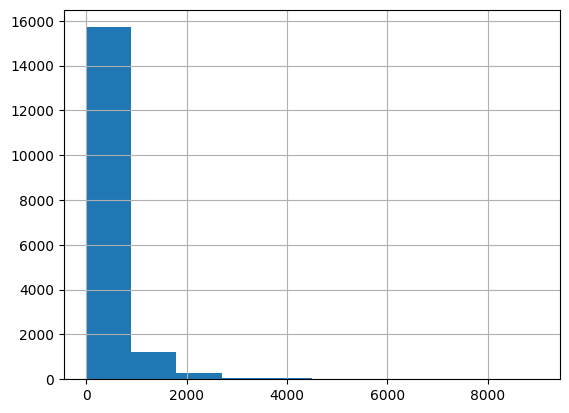

In [5]:
df['likes'].hist()


## Importing data and concating on xthan json files

In [ ]:
##Preprocessing 1:
# We exrtact the categories of the items in the 'items' category. We ll use them later
# We can get the ratio of likes per views to get a better metric wheter the set is actually good or not
# We can then log it. First we the the ratio column and then we log it. Logging is the final step otherwise there is no differenece.
# Moreover we can cut the bottom %5 or some other ratio in order to get the outfits tha have been viewed a decemnt amount of times
#train_df['categories_list'] = train_df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])

#train_df['likes_to_views_ratio'] = train_df['likes']/train_df['views']

#train_df.drop(columns=(['items','image','set_url']),axis=1,inplace=True)

In [ ]:
##! OPTIONANL for testing
# #if we want to drop a percent of our dataset to crop the outliers
# lower_threshold = df['views'].quantile(0.05)
# upper_threshold = df['views'].quantile(0.95)
#np.log(train_df.likes/train_df.views).hist()
# df_filtered = train_df[(train_df['views'] >= lower_threshold) & (train_df['views'] <= upper_threshold)]


In [2]:
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/train_no_dup.json') as f:
    data1 = json.load(f)

train_df = pd.DataFrame(data1)
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/test_no_dup.json') as f:
    data2 = json.load(f)

test_df = pd.DataFrame(data2)
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore-dataset/valid_no_dup.json') as f:
    data3 = json.load(f)

valid_df = pd.DataFrame(data3)

In [3]:
# We use this function to summarize all of our first steps of preprocessing
def preprocessing_1 (df):
    df['categories_list'] = df['items'].apply(lambda items_list: [item['categoryid'] for item in items_list])
    df['likes_to_views_ratio'] = df['likes']/df['views'] 
    df.drop(columns=(['items','image','set_url']),axis=1,inplace=True)
    return df

In [4]:
train_df = preprocessing_1(train_df)
test_df = preprocessing_1(test_df)
valid_df = preprocessing_1(valid_df)

In [5]:
valid_df

,name,views,likes,date,set_id,desc,categories_list,likes_to_views_ratio
0,THANKFUL FOR MY LULAROE PANTS!,160,26,4 months,209512492,An art collage from October 2016 by augustana ...,"[18, 188, 3336, 182]",0.162500
1,Preppy Yeti {Contest Entry},75,31,7 months,202881124,An art collage from July 2016 by kendall-dougl...,"[106, 171, 316, 182, 316]",0.413333
2,Preppy Book Cover,141,24,6 months,204980379,An art collage from August 2016 by thepreppy-e...,"[51, 3336, 182, 316, 316, 182, 51, 51]",0.170213
3,Preppy Living👒,9,8,6 months,204510570,An art collage from July 2016 by preppy-pass-g...,"[51, 316, 102, 51, 316]",0.888889
4,Winter Dresses Under $100,1634,658,One month,214272106,A fashion look from January 2017 by sinesnsing...,"[4, 25, 42, 36, 64, 53, 105, 55]",0.402693
...,...,...,...,...,...,...,...,...
1492,Celebrity Closet: White Shirt Dress,768,222,5 months,207031876,A fashion look from August 2016 by arethaman f...,"[4, 46, 318, 52]",0.289062
1493,Army,281,30,One year,187953065,A fashion look from January 2016 by catherine-...,"[11, 24, 9, 46, 37, 62, 1967]",0.106762
1494,séance de sport avec Niall #TenueSport,79,2,Two years,133190483,A fashion look from August 2014 featuring spor...,"[255, 257, 49, 76]",0.025316
1495,Gravity Falls: Wendy Corduroy,519,207,4 days,216814895,A fashion look from February 2017 by hollowpoi...,"[17, 104, 237, 42, 64, 55]",0.398844


In [18]:
all_df = pd.concat([train_df,test_df,valid_df],ignore_index=True)
all_df

,name,views,likes,date,set_id,desc,categories_list,likes_to_views_ratio
0,Casual,8743,394,One month,214181831,A fashion look from January 2017 by beebeely-l...,"[4495, 25, 27, 261, 259, 1967, 2]",0.045065
1,Being a Vans shoe model with Luke. Idk about t...,188,9,Two years,120161271,A fashion look from April 2014 featuring destr...,"[21, 237, 49, 106, 106, 106, 106, 106]",0.047872
2,These Chanel bags is a bad habit .x,562,32,Two years,143656996,12.19.14,"[104, 25, 237, 261, 37, 55]",0.056940
3,Avenger/Supernatural prp,2613,88,One year,186627934,A fashion look from January 2016 by alyssaclai...,"[11, 28, 2, 65, 52, 200, 186, 76]",0.033678
4,Boho (39),62,3,5 months,206969379,A fashion look from August 2016 by kate-goida ...,"[11, 236, 9, 261, 64, 62, 1967, 200]",0.048387
...,...,...,...,...,...,...,...,...
21884,Celebrity Closet: White Shirt Dress,768,222,5 months,207031876,A fashion look from August 2016 by arethaman f...,"[4, 46, 318, 52]",0.289062
21885,Army,281,30,One year,187953065,A fashion look from January 2016 by catherine-...,"[11, 24, 9, 46, 37, 62, 1967]",0.106762
21886,séance de sport avec Niall #TenueSport,79,2,Two years,133190483,A fashion look from August 2014 featuring spor...,"[255, 257, 49, 76]",0.025316
21887,Gravity Falls: Wendy Corduroy,519,207,4 days,216814895,A fashion look from February 2017 by hollowpoi...,"[17, 104, 237, 42, 64, 55]",0.398844


In [24]:
all_df

,name,views,likes,date,set_id,desc,categories_list,likes_to_views_ratio
0,Casual,8743,394,One month,214181831,A fashion look from January 2017 by beebeely-l...,"[4495, 25, 27, 261, 259, 1967, 2]",0.045065
1,Being a Vans shoe model with Luke. Idk about t...,188,9,Two years,120161271,A fashion look from April 2014 featuring destr...,"[21, 237, 49, 106, 106, 106, 106, 106]",0.047872
2,These Chanel bags is a bad habit .x,562,32,Two years,143656996,12.19.14,"[104, 25, 237, 261, 37, 55]",0.056940
3,Avenger/Supernatural prp,2613,88,One year,186627934,A fashion look from January 2016 by alyssaclai...,"[11, 28, 2, 65, 52, 200, 186, 76]",0.033678
4,Boho (39),62,3,5 months,206969379,A fashion look from August 2016 by kate-goida ...,"[11, 236, 9, 261, 64, 62, 1967, 200]",0.048387
...,...,...,...,...,...,...,...,...
21884,Celebrity Closet: White Shirt Dress,768,222,5 months,207031876,A fashion look from August 2016 by arethaman f...,"[4, 46, 318, 52]",0.289062
21885,Army,281,30,One year,187953065,A fashion look from January 2016 by catherine-...,"[11, 24, 9, 46, 37, 62, 1967]",0.106762
21886,séance de sport avec Niall #TenueSport,79,2,Two years,133190483,A fashion look from August 2014 featuring spor...,"[255, 257, 49, 76]",0.025316
21887,Gravity Falls: Wendy Corduroy,519,207,4 days,216814895,A fashion look from February 2017 by hollowpoi...,"[17, 104, 237, 42, 64, 55]",0.398844


In [ ]:
all_df

In [7]:
# Every number corresponds to a subcategory listed in a txt file in the dataset
# Then we map these subcategories to our categories
category_mapping = {
"Tops": [11, 15, 17,18,19,21,343,104,252,272,273,275,286,309,342,4454,4495,4496, 4497, 4498, 341 ],

"Bottoms": [7, 8, 9, 10, 27, 28, 29, 237, 238, 239, 240, 241, 251, 253, 254, 255, 278, 279, 280, 287, 288, 4452, 4458, 4459, 332],

"Accessories": [40, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 67, 105, 106, 107, 270, 299, 300, 301, 302, 303, 304, 305, 4447, 4463, 4466, 4467, 4470, 4472, 4523, 4524, 4525, 1967],

"Shoes": [41, 42, 43, 46, 47, 48, 49, 50, 261, 262, 263, 264, 265, 266, 267, 268, 291, 292, 293, 294, 295, 296, 297, 298, 4464, 4465, 4522],

"Outwear": [23, 24, 25, 26, 256, 276, 277, 289, 4455, 4457, 4456,236 ],

"Bags": [35, 36, 37, 38, 231, 258, 259, 290, 4461, 4462, 4474, 4520, 4521],

"Onepieces": [3, 4, 5, 6, 30, 75, 243, 244, 281, 4486, 4516, 1606, 1607]}

In [8]:
# Our goal is to filter the outfits. Firstly we will try to extract the outfits tha may belonging to mens fashion
# In order to do it we locate the categories that refer to mens fashion according to the txt file.
# Then we try extracting inforamtion on the string columns (describe and name) 
# Initially we check for the outfits that may belong to men fashion
men_subcategories = [343,272,273,275,276,277,278,279,280,281,282,283,284,286,287,288,289,290,291,
                     292,293,294,295,296,297,298,299,300,301,302,303,304,305,342,4447,4454,4455,
                     4456,4457,4458,4459,4460,4461,4462,4463,4464,4465,4466,4467,4472,4474,4497,
                     4498,4520,4521,4522,4523,4524,4525,341]

In [11]:
all_df.desc.str.lower()

0        a fashion look from january 2017 by beebeely-l...
1        a fashion look from april 2014 featuring destr...
2                                                 12.19.14
3        a fashion look from january 2016 by alyssaclai...
4        a fashion look from august 2016 by kate-goida ...
                               ...                        
21884    a fashion look from august 2016 by arethaman f...
21885    a fashion look from january 2016 by catherine-...
21886    a fashion look from august 2014 featuring spor...
21887    a fashion look from february 2017 by hollowpoi...
21888    a fashion look from february 2017 by ramiza-ro...
Name: desc, Length: 21889, dtype: object

In [12]:
all_df.name.str.lower()

0                                                   casual
1        being a vans shoe model with luke. idk about t...
2                      these chanel bags is a bad habit .x
3                                 avenger/supernatural prp
4                                                boho (39)
                               ...                        
21884                  celebrity closet: white shirt dress
21885                                                 army
21886               séance de sport avec niall #tenuesport
21887                        gravity falls: wendy corduroy
21888           apples of gold jewelry - black-akoya-pearl
Name: name, Length: 21889, dtype: object

In [13]:
all_df.desc = all_df.desc.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)

In [189]:
all_df.name = all_df.name.str.lower().str.replace('[{}]'.format(string.punctuation), ' ', regex=True)

In [186]:
men_df = all_df[all_df.desc.str.contains(r'\b(men|man)\b', case=False)]

<ipython-input-186-4f35701ff81f>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  men_df = all_df[all_df.desc.str.contains(r'\b(men|man)\b', case=False)]


In [8]:
def common_member(a, b):
    return list(np.intersect1d(a, b))

In [207]:
a = men_subcategories
b = all_df['categories_list'][1]

In [209]:
all_df.set_id

0        214181831
1        120161271
2        143656996
3        186627934
4        206969379
           ...    
21884    207031876
21885    187953065
21886    133190483
21887    216814895
21888    216690089
Name: set_id, Length: 21889, dtype: object

In [9]:

men_fashion = []
count = 0
for i in range(0,len(all_df)):
    b = all_df['categories_list'][i]
    common_elements = common_member(men_subcategories, b)

    if not common_elements:
        continue
    else:    
        print("Index is: ",i, common_elements)
        count = count +1
        men_fashion.append(all_df['set_id'][i])
              

NameError: name 'all_df' is not defined

In [11]:
men_fashion

[]

In [ ]:
def has_common_elements(row):
    row_set = set(row['categories_list'])
    return bool(row_set.intersection(men_subcategories))

In [217]:
def has_common_elements(row):
    row_set = set(row['categories_list'])
    return bool(row_set.intersection(men_subcategories))

In [218]:
filtered_df2 = all_df[all_df.apply(has_common_elements, axis=1)]


In [12]:
filtered_df2

NameError: name 'filtered_df2' is not defined

In [206]:
count

1012